# Compare wind from NCEP1 and 20CR and test merging

In [1]:
import pathlib
import netCDF4
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
local = True

In [4]:
# directory to the sealevel 
src_dir = pathlib.Path('~/Projects/SmallProjects/ZeespiegelMonitor/zsm_code/').expanduser()

In [5]:
def make_wind_df(lat_i=53, lon_i=3, product='NCEP1'):
    """create a dataset for wind, for 1 latitude/longitude"""
    
    if product=='NCEP1':
        # the following url's are not available during a government shutdown
        u_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/uwnd.10m.mon.mean.nc'
        v_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/vwnd.10m.mon.mean.nc'

        if local:
            u_file = pathlib.Path(src_dir / 'data/noaa/uwnd.10m.mon.mean.nc').expanduser()
            v_file = pathlib.Path(src_dir / 'data/noaa/vwnd.10m.mon.mean.nc').expanduser()
            
    elif product=='20CR':
        if local:
            u_file = pathlib.Path(src_dir / 'data/noaa/20cr.uwnd.10m.mon.mean.nc').expanduser()
            v_file = pathlib.Path(src_dir / 'data/noaa/20cr.vwnd.10m.mon.mean.nc').expanduser()
        else:
            print(f'ERROR: The reanalysis product {product} first needs to be downloaded')
            
    else:
        print(f'Reanalysis product not available: {product}')

    # open the 2 files
    ds_u = netCDF4.Dataset(u_file)
    ds_v = netCDF4.Dataset(v_file)
    
    # read lat,lon, time from 1 dataset
    lat, lon, time = ds_u.variables['lat'][:], ds_u.variables['lon'][:], ds_u.variables['time'][:]
    
    # check with the others
    lat_v, lon_v, time_v = ds_v.variables['lat'][:], ds_v.variables['lon'][:], ds_v.variables['time'][:]
    assert (lat == lat_v).all() and (lon == lon_v).all() and (time == time_v).all()
    
    # convert to datetime
    # Now defaults to return cftime dates https://github.com/Unidata/cftime/issues/136
    # cftime dates are not recognized by pandas
    # in cftime < 1.2.1 there is a bug that this flag doesn't not function properly
    t = netCDF4.num2date(time, ds_u.variables['time'].units, only_use_cftime_datetimes=False)
    
    def find_closest(lat, lon, lat_i=lat_i, lon_i=lon_i):
        """lookup the index of the closest lat/lon"""
        Lon, Lat = np.meshgrid(lon, lat)
        idx = np.argmin(((Lat - lat_i)**2 + (Lon - lon_i)**2))
        Lat.ravel()[idx], Lon.ravel()[idx]
        [i, j] = np.unravel_index(idx, Lat.shape)
        return i, j
    
    # this is the index where we want our data
    i, j = find_closest(lat, lon)
    
    # get the u, v variables
    print('found point', lat[i], lon[j])
    u = ds_u.variables['uwnd'][:, i, j]
    v = ds_v.variables['vwnd'][:, i, j]

    # compute derived quantities
    speed = np.sqrt(u**2 + v**2)
    
    # compute direction in 0-2pi domain
    direction = np.mod(np.angle(u + v * 1j), 2*np.pi)
    
    # put everything in a dataframe
    wind_df = pd.DataFrame(data=dict(u=u, v=v, t=t, speed=speed, direction=direction))
    wind_df = wind_df.set_index('t')


    # return it
    return wind_df

def make_annual_wind_df(wind_df):
    '''Compute annual averaged wind dataset from monthly wind dataset'''
    
    # label set to xxxx-01-01 of the current year
    annual_wind_df = wind_df.groupby(pd.Grouper(freq='1Y', label='left')).mean()
    annual_wind_df.index = annual_wind_df.index + datetime.timedelta(days = 1)
    annual_wind_df['speed'] = np.sqrt(annual_wind_df['u']**2 + annual_wind_df['v']**2)
    annual_wind_df['direction'] = np.mod(np.angle(annual_wind_df['u'] + annual_wind_df['v'] * 1j), 2*np.pi)
    
    return annual_wind_df

In [6]:
wind_ncep1_df = make_wind_df()
annual_wind_ncep1_df = make_annual_wind_df(wind_ncep1_df)

found point 52.3799 3.75


In [7]:
wind_20cr_df = make_wind_df(product='20CR')
annual_wind_20cr_df = make_annual_wind_df(wind_20cr_df)

found point 53.0 3.0


## Compare NCEP1 and 20CR

Text(0, 0.5, 'Annual zonal wind speed [m/s]')

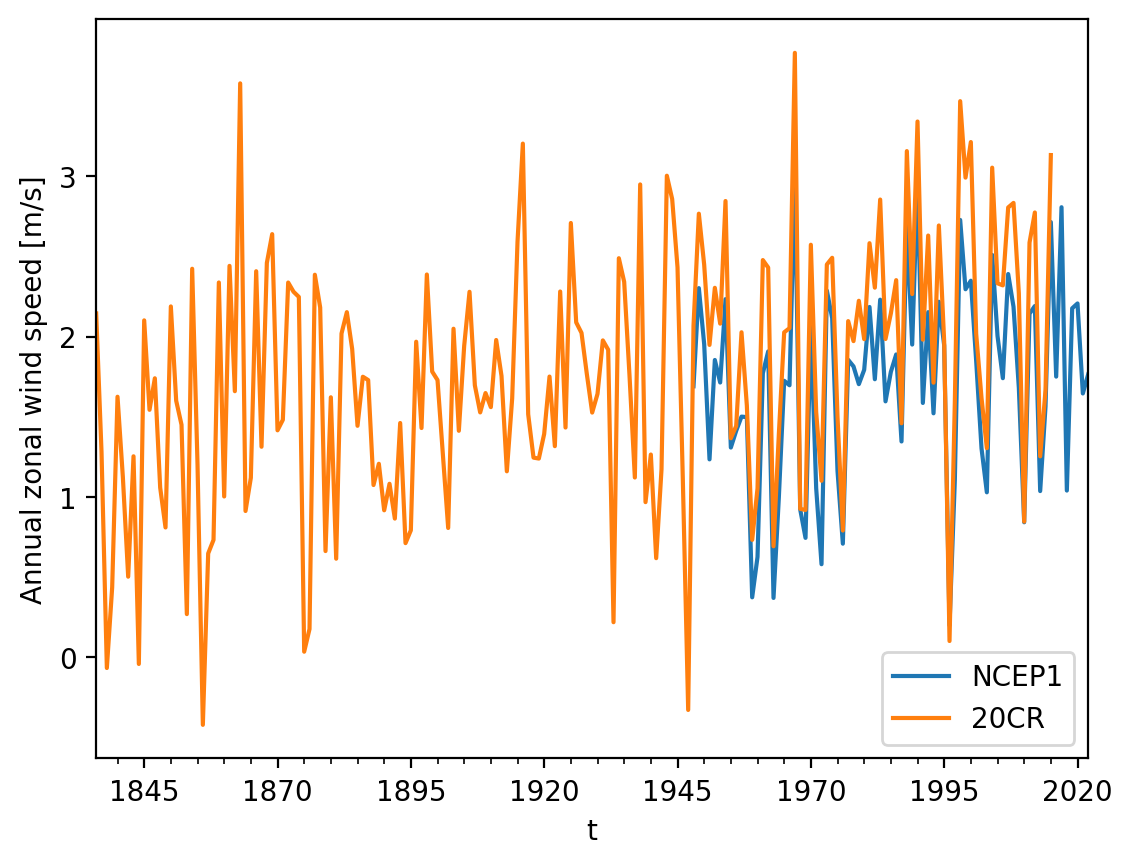

In [8]:
annual_wind_ncep1_df['u'].plot(label='NCEP1')
annual_wind_20cr_df['u'].plot(label='20CR')

plt.legend()
plt.ylabel('Annual zonal wind speed [m/s]')

## Merge the two datasets

In [9]:
def combine_linear_scaling(df1, df2):
    '''Combine two reanalysis products with a linear scaling using the most 
    recent one as reference'''
    
    date_s = df2.index[0]
    date_e = df1.index[-1]
    
    df1_cor = df1.copy()
    
    df1_cor = df1 - df1.loc[date_s:date_e].mean()
    df1_cor = df1_cor*df2.loc[date_s:date_e].std()/df1_cor.loc[date_s:date_e].std()
    df1_cor = df1_cor + df2.loc[date_s:date_e].mean()

    combined_df = pd.concat([df1_cor.loc[:date_s][:-1], df2.loc[date_s:]])
    
    return combined_df

In [10]:
combined_df = combine_linear_scaling(wind_20cr_df, wind_ncep1_df)

In [11]:
combined_df.loc['1847-10-01':]

,u,v,speed,direction
t,,,,
1847-10-01,-0.011151,1.911906,1.876951,1.704188
1847-11-01,2.287811,2.505996,3.383458,0.903928
1847-12-01,0.161188,3.305152,3.133115,1.639970
1848-01-01,-3.204889,1.434384,3.664784,2.864373
1848-02-01,4.238095,2.540014,5.040873,0.614251
...,...,...,...,...
2022-04-01,-0.273333,-1.823333,1.843707,4.563589
2022-05-01,2.010484,0.094355,2.012697,0.046897
2022-06-01,0.927500,0.003333,0.927506,0.003594


In [12]:
annual_combined_df = make_annual_wind_df(combined_df)

Text(0, 0.5, 'Annual zonal wind speed [m/s]')

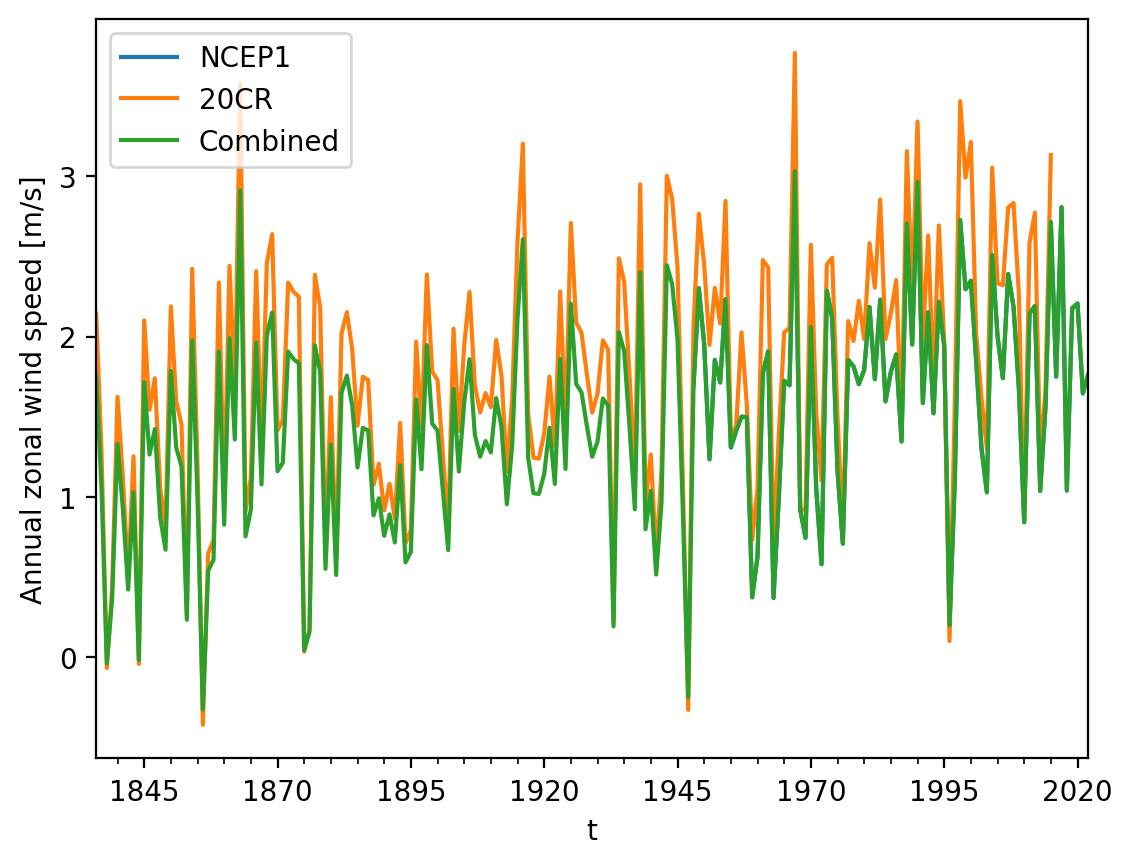

In [13]:
annual_wind_ncep1_df['u'].plot(label='NCEP1')
annual_wind_20cr_df['u'].plot(label='20CR')
annual_combined_df['u'].plot(label='Combined')

plt.legend()
plt.ylabel('Annual zonal wind speed [m/s]')
